# Place cell analyisis

In [1]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [2]:
import sys
sys.path.append('../src') # Add src folder to path.
import place_cells as pc # Import my place_cell functions from /src.

In [3]:
# load data
data_folder = Path(r"Z:\davide\2p_data\441406_fiano")
#Z:\davide\2p_data\441394_ribolla
animal = '441406_fiano'
date =  '20230331'

save_plots = True
output_folder = Path('./imgs')
output_folder.mkdir(exist_ok=True,parents=True)

#data_path = data_folder.joinpath(f'{animal}/{date}') #duplication error in path?
data_path = data_folder.joinpath(f'{date}')

trial_data_file = data_path.joinpath('trial_data.csv')
trial_data = pd.read_csv(trial_data_file)

bdata_file = data_path.joinpath('behaviour_data.pickle')
with open(bdata_file,'rb') as file:
    b_data = pickle.load(file)

ndata_file = data_path.joinpath('neural_data.pickle')
with open(ndata_file,'rb') as file:
    n_data = pickle.load(file)


scanner_fps = 30.
vr_fps = 1000.

end_time = n_data['traces'].shape[1]/scanner_fps
scanner_times = np.arange(0, end_time, 1./scanner_fps)

position = b_data["position"]
times = b_data["time"]
spikes = n_data["deconvolved"]

spike_times = []
for s in spikes:
    spike_times.append(scanner_times[s])

In [4]:
env = 1

subset = trial_data[trial_data['env_label'] == env]
norm_pos,sliced_time,sliced_spikes = pc.slice_data(subset,position,times,spike_times)
spike_positions = [np.interp(s,sliced_time , norm_pos) for s in sliced_spikes]

In [5]:
# plot the spike for each cell in time and position, interactively
from ipywidgets import interact
import ipywidgets as widgets

def plot_cell(cell):

    plt.figure(figsize=(20,5))
    plt.scatter(sliced_time,norm_pos,s=0.01)
    plt.scatter(sliced_spikes[cell],spike_positions[cell],c='r')

interact(plot_cell, cell = widgets.IntSlider(min=0, max=(len(sliced_spikes)),step=1, value=0))

interactive(children=(IntSlider(value=0, description='cell', max=231), Output()), _dom_classes=('widget-intera…

<function __main__.plot_cell(cell)>

In [6]:
firing_rate_maps, occupancy = pc.compute_firing_rate_maps(spike_positions, norm_pos)
spatial_info = pc.calculate_spatial_info(firing_rate_maps, occupancy)

C:\Users\marc_\AppData\Local\Temp\ipykernel_3688\2650376211.py:1: RuntimeWarning: invalid value encountered in true_divide
  norm_maps = firing_rate_maps/np.max(firing_rate_maps,axis=1)[:,np.newaxis]


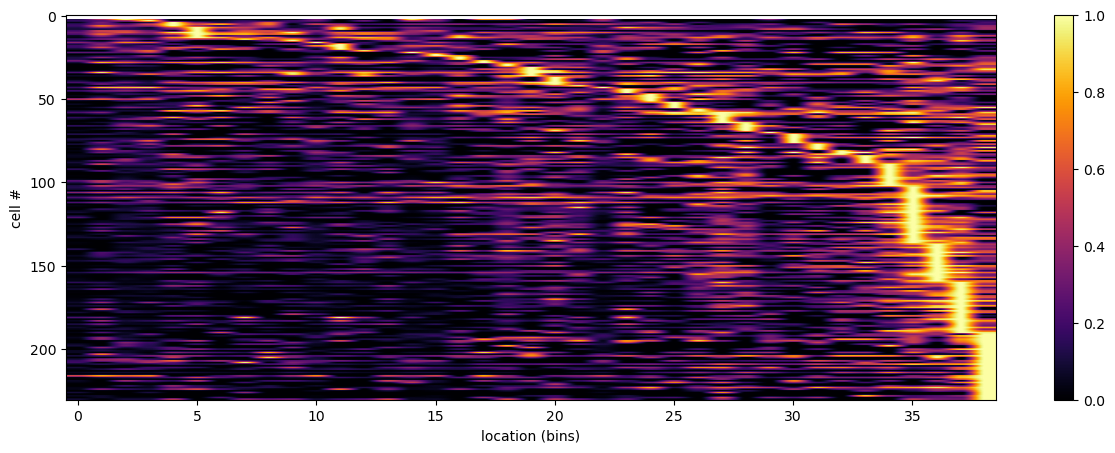

In [7]:
norm_maps = firing_rate_maps/np.max(firing_rate_maps,axis=1)[:,np.newaxis]
plt.figure(figsize=(15, 5))

# Find the location of the peak firing rate for each cell
peak_locations = norm_maps.argmax(axis=1)

# Sort the firing rate maps based on the peak locations
ix = np.argsort(peak_locations)

# Plot the sorted firing rate maps
plt.imshow(norm_maps[ix, :], cmap="inferno", aspect="auto")

# Set the x-axis label
plt.xlabel("location (bins)")

# Set the y-axis label
plt.ylabel("cell #")

# Add a colorbar to the plot
plt.colorbar()

In [8]:
# NULL
n_shuff = 20
null_spatial_info_distr = []

for n in range(n_shuff):
    shuff_spike_times = pc.shuffle_spikes(spike_times,scanner_times[-1])
    shuff_norm_pos,shuff_sliced_time,shuff_sliced_spikes = pc.slice_data(subset,position,times,shuff_spike_times)
    shuff_spike_positions = [np.interp(s,shuff_sliced_time , shuff_norm_pos) for s in shuff_sliced_spikes]
    
    shuff_firing_rate_maps, shuff_occupancy = pc.compute_firing_rate_maps(shuff_spike_positions, shuff_norm_pos)
    shuff_spatial_info = pc.calculate_spatial_info(shuff_firing_rate_maps, shuff_occupancy)

    for s in shuff_spatial_info:
        null_spatial_info_distr.append(s)

Text(0, 0.5, 'probability density')

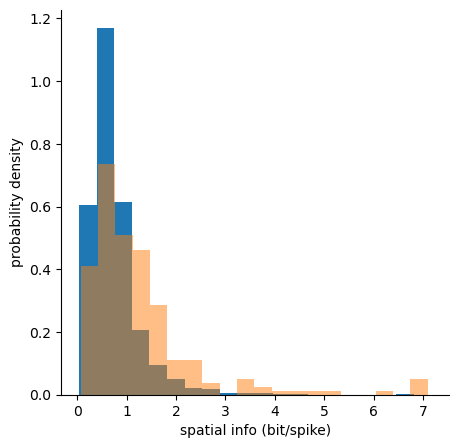

In [9]:
plt.figure(figsize=(5,5))
plt.hist(null_spatial_info_distr,density=True,bins=20);
plt.hist(spatial_info,density=True,alpha=0.5,bins=20);
sns.despine()
plt.xlabel('spatial info (bit/spike)')
plt.ylabel('probability density')

In [10]:
place_cell_th = np.percentile(null_spatial_info_distr,95)
n_place_cells = 0
for i in spatial_info:
    if i>place_cell_th:
        n_place_cells += 1

print(f'place cells {n_place_cells}/{len(spatial_info)}, fraction: {n_place_cells/len(spatial_info)}')

place cells 49/229, fraction: 0.21397379912663755
